In [1]:
import librosa

In [2]:
num_labels = 6 
emotions_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
class_to_idx = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
idx_to_class = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip3 install pickle5
path_to_protocol5 = '/content/drive/MyDrive/Colab_Notebooks/Val_AFEW/enet_b0_8_afew_extra.pickle'

import pickle5 as p
import pickle


with open(path_to_protocol5, "rb") as fh:
  train, val = p.load(fh)


     |████████████████████████████████| 256 kB 28.6 MB/s 


In [5]:
import pickle
model_name = 'enet_b0_8'
MODEL2EMOTIW_FEATURES=model_name+'_afew_torch.pickle' 

print(MODEL2EMOTIW_FEATURES)

enet_b0_8_afew_torch.pickle


In [12]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from random import shuffle
from tqdm.notebook import tqdm
import pandas as pd
from time import time

import pickle

from scipy.special import softmax
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#from scipy.misc import imread, imresize

%matplotlib inline

In [7]:
DATA_DIR=r'/content/drive/MyDrive/Colab_Notebooks/AudioVideo1/AudioVideo'
IMG_SIZE = 224

emotion_to_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}

In [8]:
def create_dataset(filename2features,data_dir):
    x = []
    y = []
    has_faces=[]
    ind=0
    for class_name in emotion_to_index:
        for filename in tqdm(os.listdir(os.path.join(data_dir,class_name))):
            fn=os.path.splitext(filename)[0] # goes through files names
            if not fn in filename2features:
                continue
            features=filename2features[fn]
            total_features=None
            #print(len(features))
            if True:
                if len(features[0])!=0:
                    cur_features=features[0][features[-1]==1]
                #print(prev,features.shape)
            else:
                cur_features=features[0]
            if len(cur_features)==0:
                has_faces.append(0)
                total_features=np.zeros_like(feature)
            else:
                has_faces.append(1)
                #mean_features=features.mean(axis=0)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                #feature = np.concatenate((max_features, std_features), axis=None)
                #feature=max_features

                total_features=feature
            
            if total_features is not None:
                x.append(total_features)
                y.append(emotion_to_index[class_name])
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train_enet, y_train_enet, has_faces_train = create_dataset(train, os.path.join(DATA_DIR, 'Train_AFEW'))
x_test_enet, y_test_enet, has_faces_test = create_dataset(val, os.path.join(DATA_DIR, 'Val_AFEW'))

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

(773, 5120) (773,)


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

(383, 5120) (383,)


In [9]:
from sklearn import svm,metrics,preprocessing

x_train_norm=preprocessing.normalize(x_train_enet,norm='l2')
x_test_norm=preprocessing.normalize(x_test_enet,norm='l2')

In [50]:
import xgboost as xgb
clf = xgb.XGBClassifier(n_estimators=1000, use_label_encoder=False)
 
clf.fit(x_train_norm[has_faces_train==1], y_train_enet[has_faces_train==1])
y_pred = clf.predict(x_test_norm)

print("Accuracy:",metrics.accuracy_score(y_test_enet[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test_enet, y_pred))

Accuracy: 0.5430809399477807
Complete accuracy: 0.5430809399477807


In [52]:
xgb_proba = clf.predict_proba(x_test_norm)
xgb_proba

array([9.8170435e-01, 1.9899800e-03, 4.0194844e-03, 3.8623592e-04,
       1.2965054e-03, 6.5923313e-04, 9.9441372e-03], dtype=float32)

In [19]:
svc_clf1 = svm.LinearSVC(C=1.1) #0.5 1.1 0.6
#clf = svm.SVC(C=10.0, gamma=1.0, kernel='rbf')
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if True:    
    svc_clf1.fit(x_train_norm[has_faces_train==1], y_train_enet[has_faces_train==1])
    y_pred = svc_clf1.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test_enet[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test_enet, y_pred))

Accuracy: 0.5926892950391645
Complete accuracy: 0.5926892950391645


In [23]:
y_pred_proba = svc_clf1.decision_function(x_test_norm)
for i in range(len(y_pred_proba)):
  y_pred_proba[i] = softmax(y_pred_proba[i])

y_pred_proba

array([[0.3893554 , 0.10488698, 0.11039285, ..., 0.08164384, 0.14255641,
        0.10062248],
       [0.30495987, 0.14751151, 0.10925048, ..., 0.05570594, 0.13410319,
        0.14461283],
       [0.17272035, 0.12909503, 0.05668739, ..., 0.29032406, 0.04237688,
        0.11907336],
       ...,
       [0.0828682 , 0.11130365, 0.23236268, ..., 0.16970073, 0.11028798,
        0.22866428],
       [0.16545736, 0.11063527, 0.17655818, ..., 0.19337141, 0.15645144,
        0.14687449],
       [0.08984737, 0.1185594 , 0.11976754, ..., 0.18202395, 0.24164848,
        0.19865369]])

array([0.00074498, 0.00036035, 0.00026689, 0.00025371, 0.00013608,
       0.0003276 , 0.00035327])

In [71]:
svc_clf = svm.SVC(C=1.1, probability=True) #0.5 1.1 0.6
#clf = svm.SVC(C=10.0, gamma=1.0, kernel='rbf')
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if True:    
    svc_clf.fit(x_train_norm[has_faces_train==1], y_train_enet[has_faces_train==1])
    y_pred = svc_clf.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)

print("Accuracy:",metrics.accuracy_score(y_test_enet[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test_enet, y_pred))

Accuracy: 0.5326370757180157
Complete accuracy: 0.5326370757180157


In [72]:
y_pred_prob = svc_clf.predict_proba(x_test_norm)

In [26]:
classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise')

confusion1 = pd.crosstab(y_test_enet, y_pred, rownames=['y_true'], colnames=['y_pred'])
confusion1.columns = classes
confusion1.index = classes

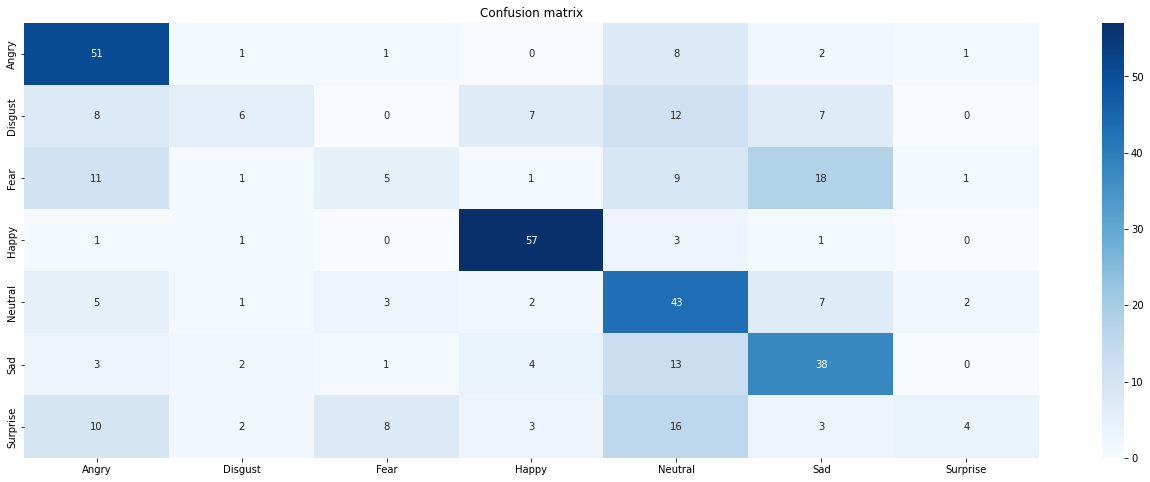

In [27]:
fig = plt.figure(figsize=(50,8))
ax1 = fig.add_subplot(121)
ax1.set_title('Confusion matrix')
sns.heatmap(confusion1, annot=True, cmap='Blues', fmt='g')

In [28]:
!pip install openvino-dev[EXTRAS]
!pip install transformers==4.11.3
!pip install openvino

     |████████████████████████████████| 5.8 MB 24.9 MB/s 
     |████████████████████████████████| 1.9 MB 54.0 MB/s 
     |████████████████████████████████| 4.2 MB 65.0 MB/s 
     |████████████████████████████████| 3.3 MB 53.6 MB/s 
     |████████████████████████████████| 31.0 MB 2.1 MB/s 
     |████████████████████████████████| 1.5 MB 43.7 MB/s 
     |████████████████████████████████| 14.1 MB 48.6 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 517 kB 51.4 MB/s 
     |████████████████████████████████| 15.7 MB 40.4 MB/s 
     |████████████████████████████████| 2.0 MB 57.6 MB/s 
     |████████████████████████████████| 298 kB 53.8 MB/s 
     |████████████████████████████████| 603 kB 49.0 MB/s 
     |████████████████████████████████| 3.3 MB 41.1 MB/s 
     |████████████████████████████████| 25.9 MB 1.7 MB/s 
     |████████████████████████████████| 26.1 MB 58.3 MB/s 
     |████████████████████████████████| 3.1 MB 47.7 MB/s 
     |███████

     |████████████████████████████████| 2.9 MB 30.5 MB/s 
  Attempting uninstall: transformers
    Found existing installation: transformers 4.16.2
    Uninstalling transformers-4.16.2:
      Successfully uninstalled transformers-4.16.2


In [29]:
import torchaudio
import torch
import numpy as np
from transformers import AutoConfig, Wav2Vec2Processor, AutoModelForAudioClassification

In [30]:
model_name_or_path = "jonatasgrosman/wav2vec2-large-xlsr-53-english"
pooling_mode = "mean"
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
target_sampling_rate = processor.feature_extractor.sampling_rate

Downloading:   0%|          | 0.00/262 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/300 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

In [31]:
def preprocess_function_eval(speech_path):   
    speech_array, sampling_rate = librosa.load(speech_path, sr = 16000)
    result = processor(speech_array, sampling_rate=target_sampling_rate, max_length=50000, padding=True, truncation=True, return_attention_mask=True)
    len_of_input_data = result['input_values'][0].shape[0]
    padded_array = np.pad(result['input_values'][0], ((0,50000-len_of_input_data)), constant_values=0)
    return padded_array

In [32]:
# config
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id=class_to_idx,
    id2label=idx_to_class,
    finetuning_task="wav2vec2_clf",    
)
setattr(config, 'pooling_mode', pooling_mode)

In [33]:
model = AutoModelForAudioClassification.from_pretrained(
    '/content/drive/MyDrive/Colab_Notebooks/group_course_work/hugging_face_w2v2', # <- insert folder with xml, config and bin
    num_labels=6,
    label2id=class_to_idx,
    id2label=idx_to_class,
) # acc 0.415144

In [34]:
from openvino.runtime import Core

ie = Core()
classification_model_xml = "/content/drive/MyDrive/Colab_Notebooks/group_course_work/fp32_w2v2/wav2vec2.xml" #<- insert here xml file where folder contains .bin weight file
model = ie.read_model(model=classification_model_xml)
model.reshape([1, 50000])
compiled_model = ie.compile_model(model=model, device_name="CPU") 
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

In [50]:
import pathlib 

path = pathlib.Path('/content/drive/MyDrive/Colab_Notebooks/Val_AFEW_Audio')

emotions_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
prob_audio = [] 

for emotion_name in emotions_list: 
  audio_path = path/emotion_name
  for audio in audio_path.iterdir():
    prob_audio.append(compiled_model([np.expand_dims(preprocess_function_eval(audio), 0)])[output_layer])

In [63]:
prob_audio

[array([[-0.06456587, -0.01675038,  0.13483259,  0.00566776,  0.00702747,
          0.12165639, -0.03896809]], dtype=float32),
 array([[-3.3055153e-02,  3.0240616e-02, -2.0306325e-05,  3.7448496e-02,
         -9.5040277e-03,  1.4551449e-01,  1.5081653e-02]], dtype=float32),
 array([[ 0.02760126,  0.03771301, -0.02814962,  0.1452739 , -0.10851409,
          0.05005184, -0.04281798]], dtype=float32),
 array([[ 0.5127754 , -0.10331216,  0.00070411, -0.12372059, -0.09437362,
         -0.06241175, -0.11830431]], dtype=float32),
 array([[-0.088361  ,  0.22336462, -0.04291773,  0.18257569, -0.08280557,
         -0.14008005, -0.05369666]], dtype=float32),
 array([[ 0.17606463, -0.08743616, -0.02876189,  0.10214496, -0.20051989,
          0.1250878 ,  0.04674681]], dtype=float32),
 array([[ 0.35463822, -0.1414111 , -0.02939235, -0.02776184, -0.0525691 ,
          0.05114849, -0.05413621]], dtype=float32),
 array([[ 0.18842345, -0.07825591, -0.00321728, -0.19243683, -0.01170277,
          0.1525

In [82]:
prob_audio1 = prob_audio
for i in range(len(prob_audio)):
  prob_audio1[i] = softmax(prob_audio[i])

prob_audio1

[array([[0.13076612, 0.13717066, 0.15962203, 0.14028049, 0.14047135,
         0.15753263, 0.13415666]], dtype=float32),
 array([[0.13439727, 0.14317906, 0.13891123, 0.14421481, 0.13760005,
         0.16067277, 0.14102496]], dtype=float32),
 array([[0.14475417, 0.14622533, 0.13690484, 0.1628305 , 0.12633306,
         0.14804076, 0.13491131]], dtype=float32),
 array([[0.23212798, 0.12536146, 0.13910338, 0.12282897, 0.12648703,
         0.13059509, 0.12349606]], dtype=float32),
 array([[0.1296361 , 0.17705436, 0.13566308, 0.16997781, 0.13035826,
         0.12310188, 0.13420863]], dtype=float32),
 array([[0.1659176 , 0.12748398, 0.13518777, 0.15409538, 0.11385285,
         0.15767165, 0.14579092]], dtype=float32),
 array([[0.19839412, 0.12080845, 0.13512835, 0.13534886, 0.13203251,
         0.14646198, 0.13182576]], dtype=float32),
 array([[0.16508798, 0.12644397, 0.1362972 , 0.11280022, 0.13514556,
         0.15926415, 0.16496094]], dtype=float32),
 array([[0.1818318 , 0.1338937 , 0.13275

In [100]:
final_prob = []
y_test = []
max_prob = -1
index = -1
for i in range(0, len(y_pred_proba)):
  final_prob.append(1*prob_audio[i]+0.65*y_pred_proba[i]+0.1*y_pred_prob[i])
  j = 0
  while j < len(final_prob[i][0]):
    if final_prob[i][0][j] > max_prob:
      index = j
      max_prob = final_prob[i][0][j]
    j += 1
  y_test.append(index)
  max_prob = -1
  index = -1

print("Complete accuracy:",metrics.accuracy_score(y_test_enet, np.array(y_test)))

Complete accuracy: 0.6031331592689295


In [86]:
# weights = np.arange(0, 1.01, 0.05)

# best_weights = []
# best_acc = 0

# for k in weights:
#   for g in weights:
#     for l in weights:
#       final_prob = []
#       y_test = []
#       max_prob = -1
#       index = -1
#       for i in range(0, len(xgb_proba)):
#         final_prob.append(k*prob_audio[i]+g*xgb_proba[i]+l*y_pred_prob[i])
#         j = 0
#         while j < len(final_prob[i][0]):
#           if final_prob[i][0][j] > max_prob:
#             index = j
#             max_prob = final_prob[i][0][j]
#           j += 1
#         y_test.append(index)
#         max_prob = -1
#         index = -1
#       if metrics.accuracy_score(y_test_enet, np.array(y_test)) > best_acc:
#         best_acc = metrics.accuracy_score(y_test_enet, np.array(y_test))
#         best_weights.append(k)
#         best_weights.append(g)
#         best_weights.append(l)

## OpenFace features + classifiers

In [ ]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from random import shuffle
from tqdm.notebook import tqdm
import pandas as pd
from time import time

import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

In [ ]:
DATA_DIR = r'D:\Users\amira\Documents\datasets\emotions\AudioVideo\openface'
IMG_SIZE = 224

emotion_to_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}
device = 'cuda:0'

In [ ]:
def create_openface_dataset(data_dir):
    x = []
    y = []
    for class_name in emotion_to_index:
        for filename in tqdm(os.listdir(os.path.join(data_dir,class_name))):
            fn=os.path.splitext(filename)[0] # goes through files names without extension
            if 'of_details' not in fn:
                openface_df = pd.read_csv(os.path.join(data_dir,class_name,filename))
                # fill zeroes with mean values on frames where openface failed to detect faces 
                openface_df.loc[openface_df[' success'] == 0] = openface_df.loc[openface_df[' success'] == 0].replace(0, openface_df.loc[openface_df[' success'] == 1].mean())
                # remove some irrelevant columns
                openface_df = openface_df.loc[:, ~openface_df.columns.isin(['frame', ' face_id', ' timestamp', ' confidence', ' success'])]

                total_features=None
                mean_features = (np.mean(openface_df, axis=0))
                std_features = (np.std(openface_df, axis=0))
                max_features = (np.max(openface_df, axis=0))
                min_features = (np.min(openface_df, axis=0))

                # join several features together
                feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                #feature = np.concatenate((max_features, std_features), axis=None)
                #feature=max_features

                total_features=feature
                
                if total_features is not None:
                    x.append(total_features)
                    y.append(emotion_to_index[class_name])

    x=np.array(x)
    y=np.array(y)
    
    print(x.shape,y.shape)
    return x,y

x_train_of, y_train_of = create_openface_dataset(os.path.join(DATA_DIR, 'Train_AFEW'))
x_test_of, y_test_of = create_openface_dataset(os.path.join(DATA_DIR, 'Val_AFEW'))


There are 24 videos from Train and 11 videos from Test where OpenFace completely failed to detect faces. In order to use normalization we have to get rid of them.

In [ ]:
mask_x_train_of = np.isnan(x_train_of)
of_has_faces_train = []

for i in range(len(mask_x_train_of)):
    of_has_faces_train.append((len(np.where(mask_x_train_of[i]==1)[0]) == 0))


mask_x_test_of = np.isnan(x_test_of)
of_has_faces_test = []

for i in range(len(mask_x_test_of)):
    of_has_faces_test.append((len(np.where(mask_x_test_of[i]==1)[0]) == 0))

In [ ]:
from sklearn import svm,metrics,preprocessing

x_train_of_norm=preprocessing.normalize(x_train_of[of_has_faces_train],norm='l2')
x_test_of_norm=preprocessing.normalize(x_test_of[of_has_faces_test],norm='l2')

In [ ]:
import xgboost as xgb
np.random.seed(1)
xgb_clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)
  
xgb_clf.fit(x_train_of, y_train_of)
y_pred_of = xgb_clf.predict(x_test_of)

print("Complete accuracy:",metrics.accuracy_score(y_test_of, y_pred_of))

Accuracy is higher when passing all data to XGBoost and the same with and without normalization

## Enet + OpenFace Features

In [ ]:
import pickle
model_name = 'enet_b0_8'
MODEL2EMOTIW_FEATURES=model_name+'_afew_torch.pickle' 

print(MODEL2EMOTIW_FEATURES)


In [ ]:
with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    filename2features_train,filename2features_val=pickle.load(handle)
print(len(filename2features_train),len(filename2features_val))

In [ ]:
def create_dataset(filename2features,data_dir):
    x = []
    y = []
    has_faces=[]
    ind=0
    for class_name in emotion_to_index:
        for filename in tqdm(os.listdir(os.path.join(data_dir,class_name))):
            fn=os.path.splitext(filename)[0] # goes through files names
            if not fn in filename2features:
                continue
            features=filename2features[fn]
            total_features=None
            #print(len(features))
            if True:
                if len(features[0])!=0:
                    cur_features=features[0][features[-1]==1]
                #print(prev,features.shape)
            else:
                cur_features=features[0]
            if len(cur_features)==0:
                has_faces.append(0)
                total_features=np.zeros_like(feature)
            else:
                has_faces.append(1)
                #mean_features=features.mean(axis=0)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                #feature = np.concatenate((max_features, std_features), axis=None)
                #feature=max_features

                total_features=feature
            
            if total_features is not None:
                x.append(total_features)
                y.append(emotion_to_index[class_name])
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train_enet, y_train_enet, has_faces_train = create_dataset(filename2features_train, os.path.join(DATA_DIR, 'Train_AFEW'))
x_test_enet, y_test_enet, has_faces_test = create_dataset(filename2features_val, os.path.join(DATA_DIR, 'Val_AFEW'))

In [ ]:
from sklearn import svm,metrics,preprocessing

x_train_enet_norm=preprocessing.normalize(x_train_enet,norm='l2')
x_test_enet_norm=preprocessing.normalize(x_test_enet,norm='l2')

Concatenate features without normalization

In [ ]:
x_train_cat = np.concatenate((x_train_enet_norm,x_train_of),axis=1)
x_test_cat = np.concatenate((x_test_enet_norm,x_test_of),axis=1)

valid_train = np.multiply(has_faces_train, of_has_faces_train)
valid_test = np.multiply(has_faces_test, of_has_faces_test)

Concatenate normalized features 

In [ ]:
x_train_cat_norm = np.concatenate((x_train_enet_norm[of_has_faces_train],x_train_of_norm),axis=1)
x_test_cat_norm = np.concatenate((x_test_enet_norm[of_has_faces_test],x_test_of_norm),axis=1)
y_train_cat_norm = y_train_enet[of_has_faces_train]
y_test_cat_norm = y_test_enet[of_has_faces_test]

valid_train_cat_norm = np.multiply(has_faces_train[of_has_faces_train], np.array(of_has_faces_train)[of_has_faces_train])
valid_test_cat_norm = np.multiply(has_faces_test[of_has_faces_test], np.array(of_has_faces_test)[of_has_faces_test])

Concatenated features from Enet and OpenFace

In [ ]:
import xgboost as xgb
np.random.seed(1)
xgb_clf = xgb.XGBClassifier(n_estimators=2000,use_label_encoder=False)

xgb_clf.fit(x_train_cat, y_train_enet)
y_pred = xgb_clf.predict(x_test_cat)

print("Complete accuracy:",metrics.accuracy_score(y_test_enet, y_pred))

Concatenated normalized features but only that have faces

In [ ]:
svc_clf = svm.LinearSVC(C=1.5)

svc_clf.fit(x_train_cat_norm, y_train_cat_norm)
y_pred = svc_clf.predict(x_test_cat_norm)

print("Accuracy:",metrics.accuracy_score(y_test_cat_norm, y_pred))
# fill in with dummy values to get complete accuracy
print("Complete accuracy:",metrics.accuracy_score(np.append(y_test_cat_norm, np.full((len(y_test_enet)-len(y_test_cat_norm)), fill_value=-1)), 
np.append(y_pred, np.full((len(y_test_enet)-len(y_test_cat_norm)), fill_value=100))))

In [ ]:
svc_clf = svm.SVC(C=2, kernel='linear', probability=True)

svc_clf.fit(x_train_cat_norm, y_train_cat_norm)
y_pred = svc_clf.predict(x_test_cat_norm)

print("Accuracy:",metrics.accuracy_score(y_test_cat_norm, y_pred))
# fill in with dummy values to get complete accuracy
print("Complete accuracy:",metrics.accuracy_score(np.append(y_test_cat_norm, np.full((len(y_test_enet)-len(y_test_cat_norm)), fill_value=-1)), 
np.append(y_pred, np.full((len(y_test_enet)-len(y_test_cat_norm)), fill_value=100))))

In [ ]:
rf_clf=RandomForestClassifier(n_estimators=2000,max_depth=10, n_jobs=-1)

rf_clf.fit(x_train_cat_norm, y_train_cat_norm)
y_pred = rf_clf.predict(x_test_cat_norm)

print("Accuracy:",metrics.accuracy_score(y_test_cat_norm, y_pred))
# fill in with dummy values to get complete accuracy
print("Complete accuracy:",metrics.accuracy_score(np.append(y_test_cat_norm, np.full((len(y_test_enet)-len(y_test_cat_norm)), fill_value=-1)), 
np.append(y_pred, np.full((len(y_test_enet)-len(y_test_cat_norm)), fill_value=100))))

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators=1500,use_label_encoder=False)

xgb_clf.fit(x_train_cat_norm, y_train_cat_norm)
y_pred = xgb_clf.predict(x_test_cat_norm)

print("Accuracy:",metrics.accuracy_score(y_test_cat_norm, y_pred))
# fill in with dummy values to get complete accuracy
print("Complete accuracy:",metrics.accuracy_score(np.append(y_test_cat_norm, np.full((len(y_test_enet)-len(y_test_cat_norm)), fill_value=-1)), 
np.append(y_pred, np.full((len(y_test_enet)-len(y_test_cat_norm)), fill_value=100))))

In [ ]:
from sklearn.ensemble import VotingClassifier

vote_clf = VotingClassifier(estimators=[('svc', svc_clf), ('rf', rf_clf), ('xgb', xgb_clf)], voting='soft')
vote_clf.fit(x_train_cat_norm, y_train_cat_norm)
y_pred = vote_clf.predict(x_test_cat_norm)

print("Accuracy:",metrics.accuracy_score(y_test_cat_norm, y_pred))
# fill in with dummy values to get complete accuracy
print("Complete accuracy:",metrics.accuracy_score(np.append(y_test_cat_norm, np.full((len(y_test_enet)-len(y_test_cat_norm)), fill_value=-1)), 
np.append(y_pred, np.full((len(y_test_enet)-len(y_test_cat_norm)), fill_value=100))))

Concatenated features but only that have faces in Openface (without normalization) and Enet 

In [ ]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators=1500,use_label_encoder=False)
 
xgb_clf.fit(x_train_cat[valid_train==1], y_train_enet[valid_train==1])
y_pred = xgb_clf.predict(x_test_cat[valid_test==1])

print("Accuracy:",metrics.accuracy_score(y_test_enet[valid_test==1], y_pred))
print("Complete accuracy:",metrics.accuracy_score(y_test_enet[valid_test==1], y_pred))

In [ ]:
np.random.seed(1)
rf_clf=RandomForestClassifier(n_estimators=2300,max_depth=12, n_jobs=-1)
    
rf_clf.fit(x_train_cat[valid_train==1], y_train_enet[valid_train==1])
y_pred = rf_clf.predict(x_test_cat[valid_test==1])

print("Accuracy:",metrics.accuracy_score(y_test_enet[valid_test==1], y_pred))
print("Complete accuracy:",metrics.accuracy_score(y_test_enet[valid_test==1], y_pred))

Due to different scale of features from Enet and OpenFace, LinearSVC failed to converge

In [ ]:
from sklearn.ensemble import VotingClassifier

vote_clf = VotingClassifier(estimators=[('rf', rf_clf), ('xgb', xgb_clf)], voting='soft')
vote_clf.fit(x_train_cat[valid_train==1], y_train_enet[valid_train==1])
y_pred = vote_clf.predict(x_test_cat[valid_test==1])
print("Accuracy:",metrics.accuracy_score(y_test_enet[valid_test==1], y_pred))
print("Complete accuracy:",metrics.accuracy_score(y_test_enet[valid_test==1], y_pred))

In [ ]:
from sklearn.ensemble import StackingClassifier

st_clf = StackingClassifier(estimators=[('rf', rf_clf), ('xgb', xgb_clf)])
st_clf.fit(x_train_cat[valid_train==1], y_train_enet[valid_train==1])
y_pred = st_clf.predict(x_test_cat[valid_test==1])
print("Accuracy:",metrics.accuracy_score(y_test_enet[valid_test==1], y_pred))
print("Complete accuracy:",metrics.accuracy_score(y_test_enet[valid_test==1], y_pred))